In [26]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [34]:
train_df = pd.read_csv('train.csv')
print(train_df.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        NaN   
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704   
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 

In [35]:
# preprocessing the dataset

# first replacing NaN values with the column's mean for all columns
for feature in train_df.columns.tolist():
  if train_df[feature].isnull().sum() > 0:
    train_df[feature].fillna(np.mean(train_df[feature]), inplace=True)
# print(train_df.isnull().sum())

# removing unnecessary columns: 'stock_id', 'date_id', 'time_id', 'row_id'
for col in train_df.columns:
  if col in ['stock_id', 'date_id', 'time_id', 'row_id']:
    train_df = train_df.drop(col, axis=1)
# print(feature_df.columns.tolist())

# separate target column from train dataset
X = train_df.drop(['target'], axis=1)
Y = train_df['target']

# applying Z-score scaling to standardize dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

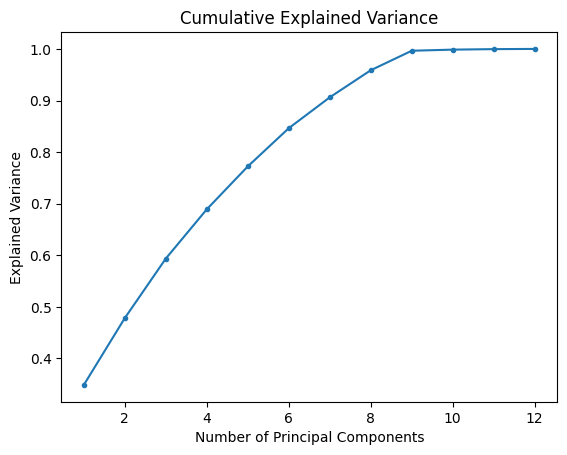

In [37]:
# implementing PCA to discover most optimal features
pca = PCA()
pca.fit(X_scaled)

# illustrate explained variance to find number of principal components that accounts for majority of variance
exp_var = pca.explained_variance_ratio_
plt.plot(range(1, len(exp_var) + 1), exp_var.cumsum(), marker='.')
plt.xlabel("Number of Principal Components")
plt.ylabel('Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

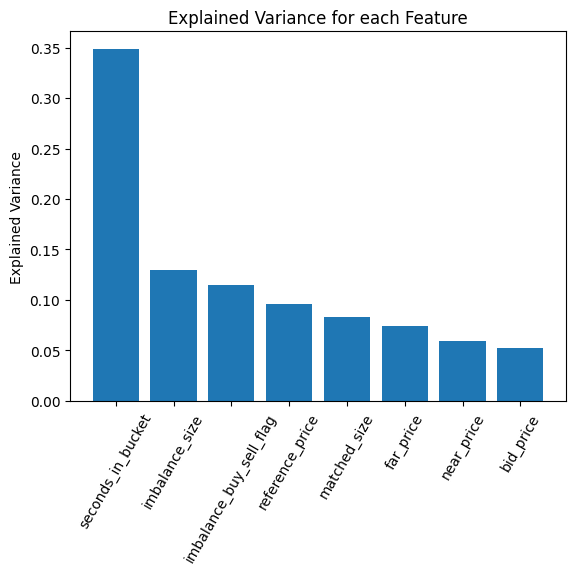

In [49]:
colnames = train_df.columns.tolist()

# create new dataset with transformed PCA from previous analysis
k = 8
k_pca = PCA(n_components=k)
f_pca = k_pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(f_pca, columns=colnames[:k])

# illustrate explained variance for each column
plt.bar(range(1, k+1), k_pca.explained_variance_ratio_)
plt.xticks(range(1, k+1), np.array(colnames[:k]), rotation=60)
plt.ylabel("Explained Variance")
plt.title("Explained Variance for each Feature")
plt.show()